# Some GBT CoDR experiments.

We implement some of the classes listed in V1.0 (Feb 2020) of the CoDR.   

* these are toy classes to show some of the functionality
* not all member functions in all classes were implemented
* very minimal error checking
* some assumed organization of PS

This should eventually reproduce Example 1 (position switching) from the GBTIDL manual. The datafile **ngc5291.fits** you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits) or locally on **/n/chara/teuben/GBT**.  We will also show regressions values with the GBTIDL spectra.

## Example

We start off with a session as a GBT user might see this:

        ps = GBTLoadPS('a.fits')        # load the SDFITS file
        ps.summary()                    # overview times, sources, scans etc.
        ps.finalspectrum()              # calibrate and time/pol/scan average
        ps.plot()                       # review the final plot 
        ps.save('a1.fits')              # save the spectrum (also SDFITS format)
        
This is an example of a well behaved spectrum. No masking, no baseline fitting, just simple averaging. 

All the way at the end of this notebook these 5 lines will be reviewed again.

In [210]:
# a few imports we need here
%matplotlib inline

from astropy.io import fits
import numpy as np
import matplotlib
import copy
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting

# Helper functions

* **dcmeantsys**:   calibration routine to get Tsys from calON/calOFF noise diode
* **uniq**:         returns unique values in the order from the list (unlike np.unique)
* **sonoff**:       helper to find the On and Off scan numbers

In [211]:
def dcmeantsys(calon, caloff, tcal, mode=0, fedge=10, nedge=None):
    """
    following the GBTIDL routine with same name, get the tsys from 
    the neighboring calon and caloff we define an extra way to set 
    the edge size, nedge, if you prefer to use number of edge channels
    instead of the inverse fraction
    
    calon/caloff is meant to reflect the state of the noise diode
    
    mode=0     do the mean before the division
    mode=1     do the mean after the division
    """
    nchan = len(calon)
    if nedge == None:
        nedge = nchan // fedge     # 10 %
    if mode == 0:
        meanoff = np.mean(caloff[nedge:-nedge])
        meandiff = np.mean(calon[nedge:-nedge] - caloff[nedge:-nedge])
        meanTsys = ( meanoff / meandiff * tcal + tcal/2.0 )
    else:
        meanTsys = np.mean( caloff[nedge:-nedge] / (calon[nedge:-nedge] - caloff[nedge:-nedge]) )
        meanTsys = meanTsys * tcal + tcal/2.0
    return meanTsys

In [212]:
def uniq(seq):
    """ from http://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-in-python-whilst-preserving-order """
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if x not in seen and not seen_add(x)]


In [213]:
def sonoff(scan, procseqn):
    """
    return the list of On and Off scan numbers
    there must be a more elegant python way to do this....
    """
    sp = {}
    for (i,j) in zip(scan, procseqn):
        sp[i] = j
    
    us1 = uniq(scan)
    up1 = uniq(procseqn)
    
    sd = {}
    for i in up1:
        sd[i] = []
        
    for s in us1:
        sd[sp[s]].append(s)

    return sd

# Spectrum

The class that contains one spectrum, something like Spectrum1D in specutils or Spectrum in pyspeckit. For now we are hardcoding the spectral axis in km/s, assuming the RESTFREQ is good. Doppler tracking ignored here for now.


In [214]:
class Spectrum(object):
    """
    contains a basic spectrum
    not used by users
    """
    def __init__(self, sp):
        if pjt1 and type(sp) == Spectrum:
            self.data  = np.copy(sp.data)
            self.meta  = sp.meta
            self.gbt   = copy.deepcopy(sp.gbt)
            self.xvals = sp.xvals
        else:   
            # assume this is a bintable
            self.data  = sp['DATA']
            self.meta  = sp
            self.gbt  = {}
            # construct a freq axis in GHz
            nchan = len(self.data)        
            crval1 = sp['CRVAL1']
            cdelt1 = sp['CDELT1']
            crpix1 = sp['CRPIX1']
            freq0  = sp['RESTFREQ']/1e9
            freq   = (crval1 + (np.arange(1,nchan+1) - crpix1) * cdelt1)/1e9
            c = 299792.458 # km/s
            vel = (1-freq/freq0)*c
            self.xvals = vel
            
    def __len__(self):
        return len(self.data)
        
        
    def stats(self, chans=None, edge=0, label=""):
        """
        show Mean,RMS,Min,Max
        """
        if chans==None:
            if edge == 0:
                c0 = 0
                c1 = len(self.data)
            else:
                c0 = edge
                c1 = -edge
        else:
            c0 = chans[0]
            c1 = chans[1]
        mean = self.data[c0:c1].mean()
        rms  = self.data[c0:c1].std()
        dmin = self.data[c0:c1].min()
        dmax = self.data[c0:c1].max()
        ndat = c1-c0
        print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),ndat))
        return (mean,rms,dmin,dmax,ndat)
    
    def flux(self, xrange=None, chans=None):
        """
        """
        dx = self.xvals[1]-self.xvals[0]
        if chans==None and xrange==None:
            flux = self.data.sum() * dx
        elif chans != None:
            c0 = chans[0]
            c1 = chans[1]
            flux = self.data[c0:c1].sum() * dx
        elif xrange != None:
            flux = 0
        else:
            flux = -1
        print("Flux %g" % flux)
        
    
    def plot(self, xrange=None, yrange=None, chans=None, label=None):
        """
        simple spectrum plot
        xrange and yrange are in physical units, e.g. xrange=[4500,5500]
        chans= are in channel numbers, e.g. chans=[2000,3000]
        """
        if xrange != None:   plt.xlim(xrange[0], xrange[1])
        if yrange != None:   plt.ylim(yrange[0], yrange[1])
        if chans == None:
            x = self.xvals
            y = self.data
        else:
            x = self.xvals[chans[0]:chans[1]]
            y = self.data[chans[0]:chans[1]]
        plt.plot(x,y)
        if 'bl' in self.gbt:
            if chans == None:
                bl = self.gbt['bl']
            else:
                bl = self.gbt['bl'][chans[0]:chans[1]]
            #print(type(x),type(bl))
            plt.plot(x,bl,'r-')          # plot full spectrum in red
            # plot the ranges...
            bl_chans = self.gbt['baseline']
            #print(bl_chans)
            for i in range(len(bl_chans)):    # loop over segments to plot in thick black
                c0 = bl_chans[i][0]
                c1 = bl_chans[i][1] 
                plt.plot(x[c0:c1],bl[c0:c1],'k-',linewidth=3)
            
        plt.xlabel("Velocity (km/s)")
        plt.ylabel("$T_A$ (K)")
        title = "Source: %s" % self.meta['OBJECT']
        if label != None:  title = title + " " + label
        plt.title(title)
        
    def smooth(self, win=11, method='hanning'):
        """
        win needs to be odd !!!
        method = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
        """
        data = np.copy(self.data)
        s=np.r_[data[win-1:0:-1],data,data[-2:-win-1:-1]]
        if method == 'flat':     # moving average
            w = np.ones(win,'d')
        else:
            w = eval('np.'+method+'(win)')
        data = np.convolve(w/w.sum(),s,mode='valid')
        w2 = (win-1)//2
        self.data = data[w2:-w2]
        
    def baseline(self, degree=2, chans=None, replace=False):
        """
        example      chans=[(1000,2000),(5000,6000)]
        """
        poly = models.Polynomial1D(degree=degree)
        fit = fitting.LinearLSQFitter()
        self.gbt['poly_degree'] = degree
        self.gbt['baseline'] = chans
        x = self.xvals
        y = np.copy(self.data)
        if chans != None:
            for i in range(len(chans)):
                c0 = chans[i][0]
                c1 = chans[i][1]
                #print("Segment",c0,c1)
                if i==0:
                    x0 = x[c0:c1]
                    y0 = y[c0:c1]
                else:
                    x0 = np.append(x0,x[c0:c1])
                    y0 = np.append(y0,y[c0:c1])
        else:
            x0 = x
            y0 = y          
        
        bl0 = fit(poly,x0,y0)
        if True:
            # residuals
            bl = bl0(x0) - y0
            print("Residuals[%d] %g %g" % (degree,bl.mean(),bl.std()))
        
        bl = bl0(x)
        #print(type(bl),type(x),type(bl))
        self.gbt['bl'] = bl
        if replace:
            self.data = self.data - bl
        
    def xy(self):
        """
        return spectrum
        """
        return (self.xvals, self.data)
             

# SDFITSLoad

This is the class that loads an SDFITS file. Normally not called by users, but by classes such as GBTLoadPS()



In [291]:
class SDFITSLoad(object):
    """
    container for a bintable from a selected HDU
    normally not used by users
    """
    def __init__(self, filename, src=None, hdu=None):
        """
        """
        print("==SDFITSLoad %s" % filename)
        self._filename = filename
        self._bintable = []
        self._binheader = []
        self._data = []
        self._hdu = fits.open(filename)  
        self._header = self._hdu[0].header
        self.load(src,hdu)
            
    def reset(self,hdu=None):
        self._bintable = []
        self._binheader = []
        self._data = []
        self._hdu = fits.open(self._filename)  
        self._header = self._hdu[0].header
        #if hdu is not None:
         #   self.load(src,hdu)
    
    def load(self, src=None, hdu=None):
        """
        for given hdu make this bintable available
        """
        self._nrows = []
        if hdu is not None:
            ldu = list([hdu])
        else:
            ldu = range(1,len(self._hdu))
        for i in ldu:
            j=i-1
            self._bintable.append(self._hdu[i])
            self._binheader.append(self._hdu[i].header)
            if src is None:
                self._data.append(self._bintable[j].data)
            else:
                wh1 = self._bintable[j].data[:]['OBJECT'] == src
                if wh1.sum() == 0:
                    srcs = np.unique(self._bintable[j].data[:]['OBJECT'])
                    raise Exception(f"Source name {src} not found in HDU {i}. Sources present are {srcs}")
                self._data.append(self._bintable[j].data[wh1])                                 
            self._nrows.append(len(self._data[j]))

    def ushow(self,bintable,key):
        return uniq(self._data[bintable][key])
    
    def naxis(self,bintable,naxis):
        nax = f'NAXIS{naxis}'
        return self._binheader[bintable][nax]
    
    def nintegrations(self,bintable,source=None):
        if source is not None:
            nint = np.shape(self._data[bintable]['OBJECT'] == source)[0]//self.npol(bintable)
        else:
            nint = np.shape(self._data[bintable])[0]//self.npol(bintable)
        return nint

    def spectra(self,bintable):
        return self._data[bintable]['DATA']
    
    def nrows(self,bintable):
        return self._nrows[bintable]

    def nchan(self,bintable):
        return np.shape(self.spectra(bintable))[1]
    
    def npol(self,bintable):
        return len(self.ushow(bintable,'CRVAL4'))
    
    def sources(self,bintable):
        return self.ushow(bintable,'OBJECT')
    
    def scans(self,bintable):
        return self.ushow(bintable,'SCAN')
    
    def __len__(self):
        return self.nrows
    
    def _summary(self,bintable):
        j=bintable
        nrows = self.naxis(j,2)
        nflds = self._binheader[j]['TFIELDS']
        restfreq = np.unique(self._data[j]['RESTFREQ'])/1.0E9
    #
        print("HDU       %d" %  (j+1))
        print("BINTABLE: %d rows x %d cols with %d chans" % (self._nrows[j],nflds,self.nchan(j)))
        print("Selected  %d/%d rows" % (self._nrows[j],nrows))
        print("Sources: ",self.sources(j))
        print("RESTFREQ:",restfreq,'GHz')
        print("Scans:   ",self.scans(j))
        print("Npol:    ",self.npol(j))   
        print("Nint:    ",self.nintegrations(j))
        
    def summary(self):
        print("File:     %s"%self._filename)
        for i in range(len(self._bintable)):
            self._summary(i)
        

In [292]:
s = SDFITSLoad('ngc5291.fits')
s.summary()

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits
HDU       1
BINTABLE: 352 rows x 46 cols with 32768 chans
Selected  352/352 rows
Sources:  ['NGC5291']
RESTFREQ: [1.420405] GHz
Scans:    [51, 52, 53, 54, 55, 56, 57, 58]
Npol:     2
Nint:     176


In [293]:
fname="/bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits"
s = SDFITSLoad(fname,src="3C286",hdu=1)

s.summary()

==SDFITSLoad /bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits
File:     /bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits
HDU       1
BINTABLE: 1040 rows x 74 cols with 32768 chans
Selected  1040/15680 rows
Sources:  ['3C286']
RESTFREQ: [1.42  1.612 1.665 1.667 1.72 ] GHz
Scans:    [6, 7]
Npol:     2
Nint:     520


# GBTLoad

This is the base class from which we derive all GBTLoad* subclasses that can load and calibrate spectra. It can also be used to load all the spectra, but there is no structure defined, e.g. to check and guide calibration manually.

In [290]:
class GBTLoad(object):
    def __init__(self, filename, src=None,hdu=1):
        """
        Holds a raw "unstructured" series of scans, normally not used by users
        """
        def ushow(name):
            uname = np.unique(self.sdfits.data2[:][name])
            print('uniq',name,uname)
            return uname          
        print("==GBTLoad %s" % filename)
        self.filename = filename
        self.sdfits = SDFITSLoad(filename, src,hdu)
        ushow('OBJECT')
        ushow('SCAN')
        ushow('SAMPLER')
        #ushow('PLNUM')
        #ushow('IFNUM')
        ushow('SIG')
        ushow('CAL')
        ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE')  
        ushow('SIDEBAND')
        
        self.nrows = self.sdfits.nrows
        self.sp = np.empty(self.nrows, dtype=Spectrum)
        for i in range(self.nrows):
            self.sp[i] = Spectrum(self.sdfits.data2[i])
            self.sp[i].gbt['row'] = i
            
    def __len__(self):
        return self.nrows
    def __getitem__(self, index):
        return self.sp[index]
    def __repr__(self):
        return self.filename
    def stats(self, chans=None):
        """
        show Mean,RMS,Min,Max
        """
        for i in range(self.nrows):
            self.sp[i].stats(chans,label="%04d" % i)
    def debug(self, vars):
        """
        show some meta data variables
        """
        for i in range(self.nrows):
            out = ""
            for v in vars:
                out = out + repr(self.sdfits.data2[i][v]) + " "
            print(out)

# PS example      
ex1 = GBTLoad('ngc5291.fits')

==GBTLoad ngc5291.fits
==SDFITSLoad ngc5291.fits


TypeError: 'int' object is not iterable

In [8]:
#   FS example 
#ex2 = GBTLoad('W3OH.fits')

In [9]:
# NOD example 
#ex3 = GBTLoad('IC1481.fits')

In [10]:
# EDGE example (has multiple sources  '3C147' 'NGC2347' 'UGC03539' )
#ex4 = GBTLoad('AGBT15B_287_35.raw.vegas.A.fits',src='NGC2347')

In [11]:
# ARGUS example
#ex5 = GBTLoad('AGBT17B_151_01.raw.vegas.A.fits')

In [12]:
#ex1.stats([3000,4000])
#ex1.debug(['DATE-OBS','CAL','SAMPLER','PROCSEQN'])

# PSScan

This class holds one PS scan, which consists of an "On" and "Off" scan.


The "Off" in particular can be constructed from other "Off"'s, or is a straight "Off" copy.

In [16]:
class PSScan(object):
    """
    Holds a PS scan - never used by users -should derive from GBTScan
    GBTLoadPS will hold one or more of such scans
    """
    #
    def __init__(self, sdfits, scan_on, scan_off):
        """
        """
        self.sdfits = sdfits
        self.status = 0
        #                           # ex1:
        self.nint = 0               # 11
        self.npol = 0               #  2
        self.on = None              # 44
        self.off = None             # 44
        self.calibrated = None      # 22
        self.timeaveraged = None    #  2
        self.polaveraged = None     #  1
        #
        self.nrows = len(scan_on)
        self.on = np.empty(self.nrows, dtype=Spectrum)
        self.off = np.empty(self.nrows, dtype=Spectrum)
        for (i,j,k) in zip(range(len(scan_on)),scan_on, scan_off):
            self.on[i] = Spectrum(sdfits.data2[j])
            self.off[i] = Spectrum(sdfits.data2[k])
            # remember the original row
            self.on[i].gbt['row'] = j
            self.off[i].gbt['row'] = k
        self.npol = 2
        self.nint = self.nrows // 4
        
    def __len__(self):
        return self.nrows
    
    def calibrate(self, verbose=False):
        """
        special PS calibration
        There are some arguments how *exactly* this is done
        """
        self.status = 1
        npolint = self.npol * self.nint
        self.calibrated = np.empty(npolint, dtype=Spectrum)
        for i in range(npolint):
            tcal = self.off[2*i].meta['TCAL']
            tcal2= self.on[2*i].meta['TCAL']
            tsys = dcmeantsys(self.off[2*i].data,  self.off[2*i+1].data,tcal)
            tsys2= dcmeantsys(self.on[2*i].data,  self.on[2*i+1].data,tcal2)
            if verbose: print(i,tcal,tsys,tsys2)
            #                 2*i is the CalON     2*i+1 the CalOFF
            #
            sig = 0.5*(self.on[2*i].data + self.on[2*i+1].data)
            ref = 0.5*(self.off[2*i].data + self.off[2*i+1].data)
            kr = self.on[2*i].gbt['row'] 
            if pjt1:
                self.calibrated[i] = Spectrum(self.on[2*i])
            else:
                self.calibrated[i] = Spectrum(self.sdfits.data2[kr])
            self.calibrated[i].data = tsys * (sig-ref) / ref
            self.calibrated[i].gbt['row'] = kr
            self.calibrated[i].gbt['tsys'] = tsys
            # fix the meta data ; most of it is ok
    def timeaverage(self):
        """
        time averaging
        """
        self.status = 2
        self.timeaveraged = np.empty(self.npol, dtype=Spectrum)
        for i in range(self.npol):
            for j in range(self.nint):
                k = i*self.nint + j
                if j == 0:
                    data = self.calibrated[k].data
                else:
                    data = data + self.calibrated[k].data
            kr = self.calibrated[k].gbt['row']   
            self.timeaveraged[i] = Spectrum(self.sdfits.data2[kr])
            self.timeaveraged[i].data = data / self.nint
            self.timeaveraged[i].gbt['row'] = kr
            # fix the meta data; most of it is ok
    def polaverage(self):
        """
        polarization averaged ; needs to be stokes smart 
        """
        self.status = 3
        self.polaveraged = np.empty(1, dtype=Spectrum)
        for i in range(self.npol):
            if i==0:
                data = self.timeaveraged[i].data
            else:
                data = data + self.timeaveraged[i].data
        kr = self.timeaveraged[0].gbt['row']
        self.polaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.polaveraged[0].data = data / self.npol
        self.polaveraged[0].gbt['row'] = kr
        # fix the meta data
        
    def finalspectrum(self):
        if self.status < 1: self.calibrate()
        if self.status < 2: self.timeaverage()
        if self.status < 3: self.polaverage()
        
        

# ScanAvg

ScanAvg contains not only the polarization averages, but also the Stokes.

Another helper class that is normally never called by users.

In [17]:
class ScanAvg(object):
    """
    """
    def __init__(self):
        self.avg = None
        self.stokes = []
        

# GBTLoadPS

This is the class that loads and calibrates Position Switched (PS) data

In [18]:
class GBTLoadPS(GBTLoad):
    """
    
    """
    def __init__(self, filename, src=None,hdu=1):
        """
        Load SDFITS into a PS structure
        - should also allow SDFITSLoad() list
        - should also allow filename list
        - all assumed hdu=1
        """
        def ushow(name, show=False):
            uname = np.unique(self.sdfits.data2[:][name])
            if show: print('uniq',name,uname)
            return uname
                              
        self.filename = filename
        self.sdfits = SDFITSLoad(filename, src, hdu)
        self.scan = {}
        self.scanaveraged = None
        self.status = 0
        #
        d = self.sdfits.data2
        self.object = ushow('OBJECT')
        self.scans = ushow('SCAN')
        pols = ushow('SAMPLER')
        sigs = ushow('SIG')
        cals = ushow('CAL')
        proc = ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE',True)
        dates = ushow('DATE-OBS')
        self.date0 = dates[0]
        self.date1 = dates[-1]
        # 
        sd = sonoff(self.sdfits.data2['SCAN'], self.sdfits.data2['PROCSEQN'])    
        print('OnOff scans:',sd)
        idx = np.arange(len(self.sdfits))
        for (i1,i2) in zip(sd[1],sd[2]):
            scan_on = idx[d['SCAN'] == i1]
            scan_off = idx[d['SCAN'] == i2]
            #print(i1,'on',scan_on[0],'...',scan_on[-1])
            #print(i2,'off',scan_off[0],'...',scan_off[-1])
            self.scan[i1] = PSScan(self.sdfits, scan_on, scan_off)
        
    def summary(self):
        print("GBTLoadPS %s" % self.filename)
        print("Sources:",self.object)
        print("Scans:",self.scans)
        print("Dates:",self.date0,self.date1)
        
    def stats(self, range=None):
        print('WIP')
        
    def calibrate(self, verbose=False):
        """
        calibrate each scan
        """
        self.status = 1 
        for scan in self.scan.keys():
            print("Calibrating",scan)
            self.scan[scan].calibrate(verbose)
            
    def timeaverage(self):
        """
        average in time for each scan
        """
        self.status = 2
        for scan in self.scan.keys():
            print("Timeaver",scan)
            self.scan[scan].timeaverage()
            
    def polaverage(self):
        """
        average polarizations for each scan
        """
        self.status = 3
        for scan in self.scan.keys():
            print("Polaver",scan)
            self.scan[scan].polaverage()
            
    def scanaverage(self):
        """
        averaging over scans
        """
        self.status = 4
        nscan = len(self.scan.keys())
        print("Scanaverage over %d scans" % nscan)
        self.scanaveraged = np.empty(1, dtype=Spectrum)
        for (i,scan) in zip(range(nscan),self.scan.keys()):
            kr = self.scan[scan].polaveraged[0].gbt['row']
            print('Scan %d Row %d' % (scan,kr))
            if i==0:
                data = self.scan[scan].polaveraged[0].data
            else:
                data = data + self.scan[scan].polaveraged[0].data
        self.scanaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.scanaveraged[0].data = data / nscan
        self.scanaveraged[0].gbt['row'] = kr    
        #
        if pjt1:
            sp0 = self.scan[scan].polaveraged[0]
            self.scanaveraged[0] = Spectrum(sp0)
    
    def plot(self, xrange=None, yrange=None, chans=None):
        if self.status == 3:
            for scan in self.scan.keys():
                self.scan[scan].polaveraged[0].plot(xrange,yrange,chans)
        if self.status == 4:
            self.scanaveraged[0].plot(xrange,yrange,chans)
            
    def smooth(self, win=11, method='hanning'):
        if self.status == 4:
            self.scanaveraged[0].smooth(win,method)
            
    def baseline(self, degree=2, chans=None, replace=False):
        """
        """
        if self.status == 4:
            self.scanaveraged[0].baseline(degree,chans,replace)
            
    def finalspectrum(self):
        if self.status < 1: self.calibrate()
        if self.status < 2: self.timeaverage()
        if self.status < 3: self.polaverage()
        if self.status < 4: self.scanaverage()
        print("finalspectrum is ready")
            
    def save(self, filename=None):
        print("Cannot SAVE spectra yet")
        
        

p = GBTLoadPS('ngc5291.fits')

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 46 cols with 32768 chans
Selected 352/352 rows
Sources:  ['NGC5291']
RESTFREQ: 1.420405 GHz
Scans:    [51 52 53 54 55 56 57 58]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']
OnOff scans: {1: [51, 53, 55, 57], 2: [52, 54, 56, 58]}


In [19]:
p.summary()

GBTLoadPS ngc5291.fits
Sources: ['NGC5291']
Scans: [51 52 53 54 55 56 57 58]
Dates: 2005-06-27T02:05:58.00 2005-06-27T02:28:23.93


In [20]:
# check on doppler tracking, since we ignored it
vmin = None
for s in p.scan.keys():
    for i in range(len(p.scan[s])):
        sp0 = p.scan[s].on[i]
        sp1 = p.scan[s].off[i]
        v0  = sp0.xvals[0]
        v1  = sp1.xvals[0]
        # print(s,i,v0,v1,v1-v0)
        if vmin == None:  
            vmin=v0
            print("On/Off", s,i,v0,v1,v1-v0)
print("Range of V:",vmin,v0,v0-vmin)
print("Channel Width",sp0.xvals[1]-sp0.xvals[0])

On/Off 51 0 -931.1680785556252 -931.1630130856055 0.0050654700197583225
Range of V: -931.1680785556252 -931.1393742253358 0.02870433028942898
Channel Width 0.3220539127759139


In [21]:
p.calibrate()

Calibrating 51
Calibrating 53
Calibrating 55
Calibrating 57


XX  0.31241688 0.14541201 -0.28982547 0.88212734 6001
YY  0.2646891 0.14424627 -0.25974122 0.8169561 6001
GBTIDL: XX -> 0.31242   0.14542 -0.28983     0.88213
GBTIDL: YY -> 0.26469   0.14426 -0.25974     0.81696
0 1.4243705 19.29781949520111 20.075016379356384
1 1.4243705 19.68612515926361 19.620258688926697
2 1.4243705 19.358103156089783 20.065954566001892
3 1.4243705 19.737520575523376 20.13998830318451
4 1.4243705 19.560596823692322 19.65622365474701
5 1.4243705 19.680076956748962 19.922897696495056
6 1.4243705 19.307892203330994 19.87458074092865
7 1.4243705 19.395483374595642 20.110605597496033
8 1.4243705 19.353126883506775 20.051008582115173
9 1.4243705 19.37155568599701 19.657909750938416
10 1.4243705 19.718241095542908 19.659677863121033
11 1.452185 19.195132434368134 19.96463507413864
12 1.452185 19.60288542509079 19.46902960538864
13 1.452185 19.14763754606247 19.91842383146286
14 1.452185 19.568518817424774 19.931584537029266
15 1.452185 19.413369357585907 19.54745787382126

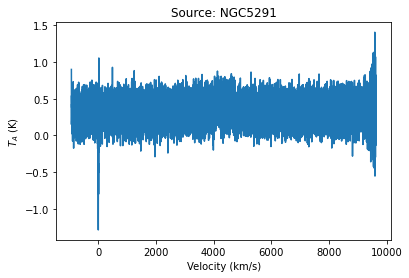

In [22]:
# details on the first calibrated scan for a regression test
p.scan[51].calibrated[ 0].plot()
p.scan[51].calibrated[ 0].stats(chans=[6000,12001],label='XX')
p.scan[51].calibrated[11].stats(chans=[6000,12001],label='YY')
print("GBTIDL: XX -> 0.31242   0.14542 -0.28983     0.88213")
print("GBTIDL: YY -> 0.26469   0.14426 -0.25974     0.81696")
p.scan[51].calibrate(verbose=True)
print("GBTIDL: Tsys(XX): Tsys:  19.30    20.08 in 0")
print("GBTIDL: Tsys(YY): Tsys:  19.20    19.96 in 11")

This is the first XX spectrum, and a very weak signal can be seen. If you know where to look.   (hint: middle of the band)

In [23]:
p.timeaverage()
p.plot()

Timeaver 51
Timeaver 53
Timeaver 55
Timeaver 57


In [24]:
p.polaverage()

Polaver 51
Polaver 53
Polaver 55
Polaver 57


In [25]:
p.scanaverage()

Scanaverage over 4 scans
Scan 51 Row 20
Scan 53 Row 108
Scan 55 Row 196
Scan 57 Row 284


In [26]:
p.finalspectrum()

finalspectrum is ready


Final   0.2953386 0.015598873 0.2429145 0.35184392 6001
GBTIDL -> 0.29487  0.015592  0.24204   0.35086
#    0.29889  0.015719  0.24665   0.35532  (old)
#    0.29791  0.015734  0.24517   0.35472  (new)


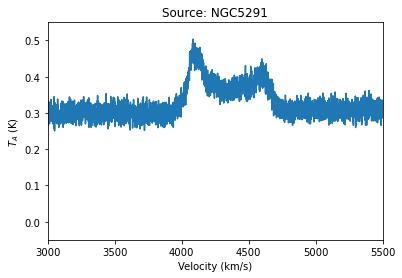

In [27]:
xrange=[3000,5500]
yrange=[-0.05,0.55]

p.scanaveraged[0].plot(xrange=xrange, yrange=yrange)
p.scanaveraged[0].stats(chans=[6000,12001],label="Final ")

print("GBTIDL -> 0.29487  0.015592  0.24204   0.35086")
print("#    0.29889  0.015719  0.24665   0.35532  (old)")
print("#    0.29791  0.015734  0.24517   0.35472  (new)")

This spectrum should have a baseline around 0.30 and the largest peak (on lowest velocity) about 0.50

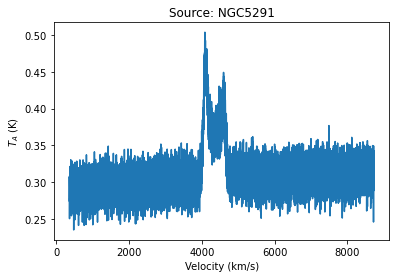

In [28]:
# wider range to see what baseline subtraction we need
p.scanaveraged[0].plot(chans=[4000,30000])
#p.smooth(win=51)
#p.scanaveraged[0].plot(chans=[4000,30000])

Scanaverage over 4 scans
Scan 51 Row 20
Scan 53 Row 108
Scan 55 Row 196
Scan 57 Row 284
Residuals[2] 4.63195e-17 0.0157342


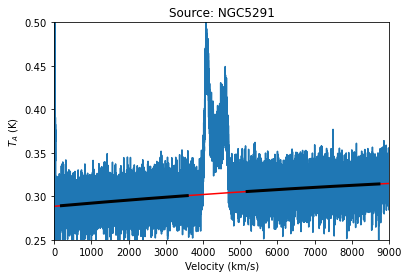

In [29]:
#    start with a new scan average
p.scanaverage()
sp9 = p.scanaveraged[0]
sp9.baseline(2,chans=[(3500,14000),(19000,30000)])
sp9.plot(xrange=[0,9000],yrange=[0.25,0.5])
#   0 -> 0.0126 rms
#   1    0.0097
#   2    0.0097
#   3    0.0097

Residuals[2] 4.63195e-17 0.0157342


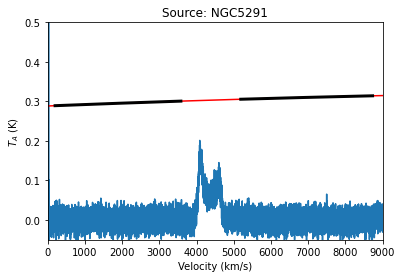

In [30]:
sp9.baseline(2,chans=[(3500,14000),(19000,30000)],replace=True)
sp9.plot(xrange=[0,9000],yrange=[-0.05,0.5])

Residuals[5] 5.16383e-20 0.00467074


 [astropy.modeling.fitting]


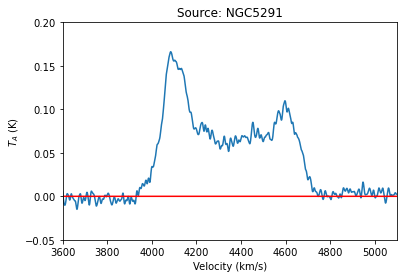

In [31]:
sp9.smooth(51)
sp9.baseline(5,chans=[(3500,14000),(19000,30000)])
sp9.plot(xrange=[3600,5100],yrange=[-0.05,0.2])

In [32]:
sp9.flux(chans=[14500,18500])
sp9.flux(chans=[14000,19000])
sp9.flux(chans=[13000,20000])
sp9.flux(chans=[12000,21000])

Flux 59.5113
Flux 59.6495
Flux 60.9284
Flux 60.6418


# Plotting raw data

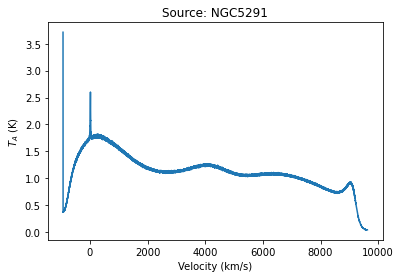

In [33]:
# p.plot(scan=51, int=0, pol=0, Raw=True)
sp0 = p.scan[51].on[0]
sp0.plot()

In [34]:
# p.plot(scan=51,int=0,pol=0, raw=True)
sp1 = p.scan[51].off[0]
(x0,y0) = sp0.xy()
(x1,y1) = sp1.xy()

In [35]:
sp0.stats(label='On')
sp1.stats(label='Off')
# STATS for row 0:  1.1189245 0.33819348 0.03492988 3.7152052 32768

On  1.1189245 0.33819348 0.03492988 3.7152052 32768
Off  1.1024007 0.33377144 0.034018766 3.5171907 32768


(1.1024007, 0.33377144, 0.034018766, 3.5171907, 32768)

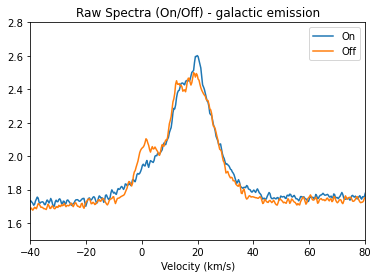

In [36]:
# first ON and OFF spectrum, centered on strong galactic
plt.plot(x0,y0,label='On')
plt.plot(x1,y1,label='Off')
plt.xlim(-40,80)
plt.ylim(1.5,2.8)
plt.xlabel("Velocity (km/s)")
plt.title("Raw Spectra (On/Off) - galactic emission")
plt.legend();

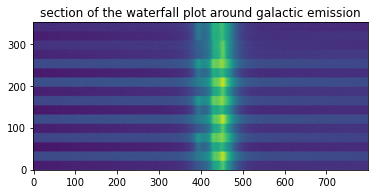

In [37]:
# waterfall plot
spectra = p.sdfits.spectra
plt.imshow(spectra[:,2500:3300],origin='lower')
plt.title("section of the waterfall plot around galactic emission");

# Plotting some calibrated data 

This shows that integrations and polarizations are not easily accessable to the user. I just happen to know from the first 11 are XX and the second 11 are YY. This clearly should be classed up (or so)

        p.scan[51].calibrated['XX'][0]
        
it remains to be seen if the index should be 'XX', 'YY' (i.e. a dictionary), or 0,1 (in which case numpy.reshape can be effectively used.

22 total ints per scan
first   0.31241688 0.14541201 -0.28982547 0.88212734 6001
GBTIDL: 0.31242    0.14542    -0.28983    0.88213


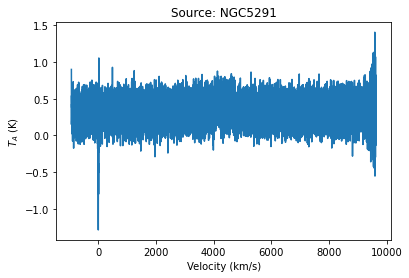

In [38]:
print(len(p.scan[51].calibrated),"total ints per scan")

# p.plot(scan=51, pol=0, int=0)
sp2 = p.scan[51].calibrated[0]
sp2.plot()
sp2.stats(chans=[6000,12001],label="first ")
print("GBTIDL: 0.31242    0.14542    -0.28983    0.88213")

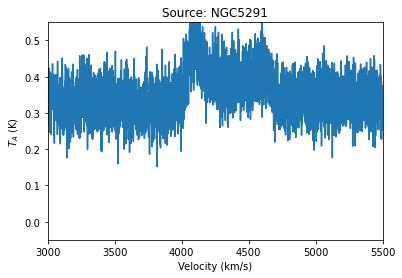

In [39]:
# p.plot(scan=51, pol=0)
sp3 = p.scan[51].timeaveraged[0]
sp3.plot(xrange=xrange, yrange=yrange)

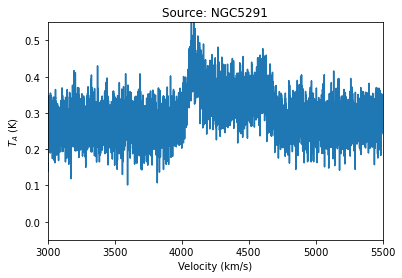

In [40]:
# p.plot(scan=51, pol=1)
sp4 = p.scan[51].timeaveraged[1]
sp4.plot(xrange=xrange, yrange=yrange)

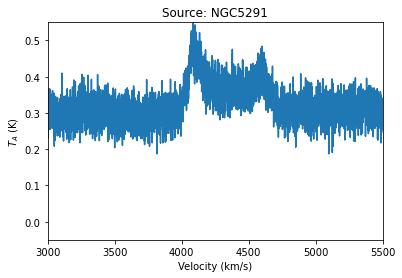

In [41]:
# one scan
# p.plot(scan=51)
sp5 = p.scan[51].polaveraged[0]
sp5.plot(xrange=xrange, yrange=yrange)

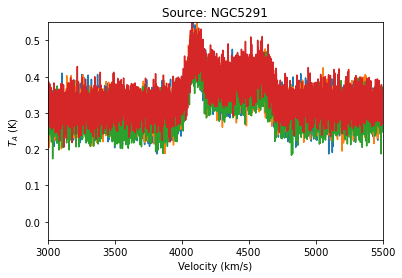

In [42]:
# all 4 scans
for s in p.scan.keys():
    sp6 = p.scan[s].polaveraged[0]
    sp6.plot(xrange=xrange, yrange=yrange)

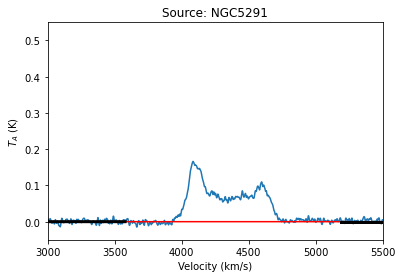

In [43]:
# final one again
# p.plot()
sp7 = p.scanaveraged[0]
sp7.plot(xrange=xrange, yrange=yrange)

In [44]:
# this doesn't work, because EDGE data really should be using a new GBTLoadTP3 or so
# ex4a = GBTLoadPS('AGBT15B_287_35.raw.vegas.A.fits',src='NGC2347')

before smooth   -0.0002024971341621059 0.00449720431611445 -0.01280419128359915 0.011043575416079036 6001
after smooth   -0.00020241021913817075 0.00446140258277941 -0.012706018746472678 0.010900818108168918 6001


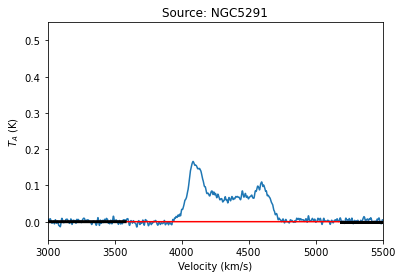

In [45]:
# smoothing - overwrites the spectrum
# repeating this cell will smooth it again...and again....
# 0: 0.2953386 0.015598873 0.2429145 0.35184392 6001
# 1: 0.2953325246309755 0.009602338242543012 0.2648628936635044 0.32654908439774566 6001
# 2: 0.2953307542541241 0.008286386497994085 0.2694530613000348 0.32276761017513705 6001
# 3: 0.2953300999052543 0.007568724039133078 0.27173553659762956 0.32096306687201087 6001
# 4: 0.2953299060968041 0.007096019075269548 0.27371836133780814 0.3196718502089972 6001
sp7.stats(chans=[6000,12001],label="before smooth ")
sp7.smooth(win=11)
sp7.plot(xrange=xrange, yrange=yrange)
sp7.stats(chans=[6000,12001],label="after smooth ");

# Recapping

Going back to the 5 line example at the start of this notebook, with a very minor twist, here is a short working version.

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 46 cols with 32768 chans
Selected 352/352 rows
Sources:  ['NGC5291']
RESTFREQ: 1.420405 GHz
Scans:    [51 52 53 54 55 56 57 58]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']
OnOff scans: {1: [51, 53, 55, 57], 2: [52, 54, 56, 58]}
GBTLoadPS ngc5291.fits
Sources: ['NGC5291']
Scans: [51 52 53 54 55 56 57 58]
Dates: 2005-06-27T02:05:58.00 2005-06-27T02:28:23.93
Calibrating 51
Calibrating 53
Calibrating 55
Calibrating 57
Timeaver 51
Timeaver 53
Timeaver 55
Timeaver 57
Polaver 51
Polaver 53
Polaver 55
Polaver 57
Scanaverage over 4 scans
Scan 51 Row 20
Scan 53 Row 108
Scan 55 Row 196
Scan 57 Row 284
finalspectrum is ready
Residuals[2] -3.06008e-17 0.00467074
Residuals[2] -3.06008e-17 0.00467074
Cannot SAVE spectra yet


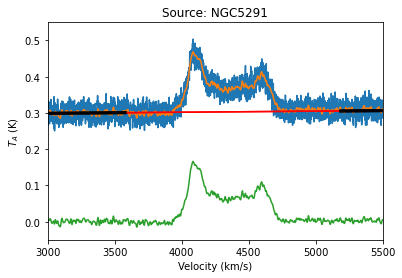

In [46]:
xrange=[3000,5500]
yrange=[-0.05,0.55]
ps = GBTLoadPS('ngc5291.fits')         # load the SDFITS file
ps.summary()                           # overview times, sources, scans etc.
ps.finalspectrum()                     # calibrate and time/pol/scan average
ps.plot(xrange=xrange, yrange=yrange)  # review the final plot 
ps.smooth(win=51)                      # smooth with a 51 window
ps.baseline(chans=[(3500,14000),(19000,30000)]) # remove 2nd degree polynomial
ps.plot(xrange=xrange, yrange=yrange)  # (over)plot
ps.baseline(chans=[(3500,14000),(19000,30000)],replace=True)
ps.plot(xrange=xrange, yrange=yrange)  #(over)plot
ps.save('a1.fits')                     # save the spectrum (also SDFITS format)

In [ ]:
xrange,yrange

---------------------------------------------------------------------

In [6]:
fname="/bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits"

In [15]:
hdu = fits.open(fname)
hdu[0].__dict__

{'_header_str': None,
 '_file': <astropy.io.fits.file._File <_io.BufferedReader name='/bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits'>>,
 '_buffer': None,
 '_header_offset': 0,
 '_data_offset': 2880,
 '_data_size': 0,
 '_data_replaced': False,
 '_data_needs_rescale': False,
 '_new': False,
 '_output_checksum': False,
 '_checksum': None,
 '_checksum_valid': None,
 '_datasum': None,
 '_datasum_valid': None,
 '_do_not_scale_image_data': False,
 '_uint': True,
 '_scale_back': None,
 '_bzero': 0,
 '_bscale': 1,
 '_axes': [],
 '_bitpix': 8,
 '_gcount': 1,
 '_pcount': 0,
 '_blank': None,
 '_orig_bitpix': 8,
 '_orig_blank': None,
 '_orig_bzero': 0,
 '_orig_bscale': 1,
 '_modified': False,
 '_header': SIMPLE  =                    T / file does conform to FITS standard             
 BITPIX  =                    8 / number of bits per data pixel                  
 NAXIS   =                    0 / number of data axes                            
 

In [47]:
ps = GBTLoadPS(fname,hdu=2) 

==SDFITSLoad /bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits
File:     /bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits   HDU 2
BINTABLE: 17080 rows x 74 cols with 4096 chans
Selected 17080/17080 rows
Sources:  ['NGC6946']
RESTFREQ: 1.42 GHz
Scans:    [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
uniq OBSMODE ['DecLatMap:NONE:TPWCAL' 'Track:NONE:TPWCAL']
OnOff scans: {1: [14, 27], 2: [15], 3: [16], 4: [17], 5: [18], 6: [19], 7: [20], 8: [21], 9: [22], 10: [23], 11: [24], 12: [25], 13: [26]}


In [16]:
ps.bintable

NameError: name 'ps' is not defined

In [49]:
ps.summary()

GBTLoadPS /bigdisk/data/gbt/examples/mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits
Sources: ['NGC6946']
Scans: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Dates: 2017-05-17T05:23:24.00 2017-05-17T05:39:39.98


In [50]:
ps.finalspectrum()

Calibrating 14
Timeaver 14
Polaver 14
Scanaverage over 1 scans
Scan 14 Row 608
finalspectrum is ready


In [61]:
len(ps.scan[14].off)

1220